# ELE510 Image Processing with robot vision: LAB, Exercise 6, Image features detection.

## Problem 1

**Intensity edges** are pixels in the image where the intensity (or graylevel) function changes rapidly.

The **Canny edge detector** is a classic algorithm for detecting intensity edges in a grayscale image that relies on the gradient magnitude. The algorithm was developed by John F. Canny in 1986. It is a multi-stage algorithm that provides good and reliable detection.

**a)** Create the **Canny algorithm**, described at pag. 336 (alg. 7.1). For the last step (`EDGELINKING`) you can either use the algorithm 7.3 at page 338 or the `HYSTERESIS THRESHOLD` algorithm 10.3 described at page 451.
All the following images are taken from the text book [1].

![canny.png](images/canny.png)

![nonmaxsuppression.png](images/nonmaxsuppression.png)

![edgelinking.png](images/edgelinking.png)

**Remember:**

- Sigma (second parameter in the Canny algorithm) is not necessary for the calculation since the Sobel operator (in opencv) combines the Gaussian smoothing and differentiation, so the results is nore or less resistant to the noise. 
- We are defining the low and high thresholds manually in order to have a better comparison with the predefined opencv function. It is possible to extract the low and high thresholds automatically from the image but it is not required in this problem.

**b)** Test your algorithm with a image of your choice and compare your results with the predefined function in opencv: 

```python
cv2.Canny(img, t_low, t_high, L2gradient=True)
``` 
[Documentation](https://docs.opencv.org/2.4/modules/imgproc/doc/feature_detection.html?highlight=canny#canny).

### P.S. : 
<div class="alert alert-block alert-info">
The goal of this problem it is not to create a **perfect** replication of the algorithm in opencv, but to understand the various steps involved and to be able to extract the edges from an ima ge using these steps.
</div>

In [30]:
import cv2
import numpy as np

# Sobel operator to find the first derivate in the horizontal and vertical directions
def computeImageGradient(Im):
    # Sobel operator  to find the first derivate in the horizontal and vertical directions    
    ## TODO: The default ksize is 3, try different values and comment the result 
    g_x = cv2.Sobel(Im.astype(np.float32), cv2.CV_64F, 1, 0, ksize=3)
    g_y = cv2.Sobel(Im.astype(np.float32), cv2.CV_64F, 0, 1, ksize=3)


    ############################
    # Calculate the magnitude and the gradient direction like it is performed during the assignment 4 (problem 2a)
    G_mag = np.sqrt(g_x**2 + g_y**2)
    G_phase = np.arctan2(g_y, g_x)

    return G_mag, G_phase

In [31]:
def neighbors(G_phase, i, j):
    rows, cols = G_phase.shape
    neigh = []

    # Check each neighbor's coordinates before accessing
    if j - 1 >= 0:
        neigh.append(G_phase[i, j - 1])
    if j + 1 < cols:
        neigh.append(G_phase[i, j + 1])
    if i - 1 >= 0:
        neigh.append(G_phase[i - 1, j])
    if i + 1 < rows:
        neigh.append(G_phase[i + 1, j])
    if i - 1 >= 0 and j + 1 < cols:
        neigh.append(G_phase[i - 1, j + 1])
    if i + 1 < rows and j - 1 >= 0:
        neigh.append(G_phase[i + 1, j - 1])

    return neigh


In [32]:
def nonMaxSuppression(G_mag, G_phase):
    G_localmax = np.zeros(G_mag.shape)
    
    rows, cols = G_phase.shape

    for i in range(rows):
        for j in range(cols):
            # Get neighbors, considering boundaries
            neigh = neighbors(G_phase, i, j)
            
            v = G_phase[i, j]
            if G_phase[i, j] >= 7 * np.pi / 8:
                G_phase_adjusted = G_phase[i, j] - np.pi
            elif G_phase[i, j] < -np.pi / 8:
                G_phase_adjusted = G_phase[i, j] + np.pi
            elif -np.pi / 8 <= G_phase[i, j] < np.pi / 8:
                neigh = [G_phase[i, max(j - 1, 0)], G_phase[i, min(j + 1, cols - 1)]]
            elif np.pi / 8 <= G_phase[i, j] < 3 * np.pi / 8:
                neigh = [G_phase[max(i - 1, 0), min(j + 1, cols - 1)], G_phase[min(i + 1, rows - 1), max(j - 1, 0)]]
            elif -3 * np.pi / 8 <= G_phase[i, j] < 5 * np.pi / 8:
                neigh = [G_phase[max(i - 1, 0), j], G_phase[min(i + 1, rows - 1), j]]
            elif 5 * np.pi / 8 <= G_phase[i, j] < 7 * np.pi / 8:
                neigh = [G_phase[min(i + 1, rows - 1), max(j - 1, 0)], G_phase[max(i - 1, 0), min(j + 1, cols - 1)]]

            if v > neigh[0] and v > neigh[1]:
                G_localmax[i, j] = G_phase[i, j]
            else:
                G_localmax[i, j] = 0

    return G_localmax

In [39]:
import queue

def edgeLinking(G_localmax, t_low, t_high):
    I_edges = np.zeros(G_localmax.shape)
    frontier = queue.LifoQueue()
    for i in range(1, G_localmax.shape[0] - 1):
        for j in range(1, G_localmax.shape[1] - 1):
            if G_localmax[i, j] >= t_high:
                frontier.put((i, j))
                I_edges[i, j] = 1

        while not frontier.empty():
            p = frontier.get()
            for q in neighbors(p[0], p[1], G_localmax.shape[0], G_localmax.shape[1]):
                if G_localmax[q[0], q[1]] >= t_low:
                    frontier.put(q)
                    I_edges[q[0], q[1]] = 1

    return I_edges

In [55]:
"""
Function that performs the Canny algorithm.

The entire cell is locked, thus you can only test the function and NOT change it!

Input: 
    - Im: image in grayscale
    - t_low: first threshold for the hysteresis procedure (edge linking)
    - t_high: second threshold for the hysteresis procedure (edge linking)
"""
def my_cannyAlgorithm(Im, t_low, t_high):
    ## Compute the image gradient 
    G_mag, G_phase = computeImageGradient(Im)
    
    ## NonMaxSuppression algorithm 
    G_localmax = nonMaxSuppression(G_mag, G_phase)
        
    ## Edge linking
    if t_low>t_high: t_low, t_high = t_high, t_low
    I_edges = edgeLinking(G_localmax, t_low, t_high)
    print(G_phase)
    print(G_localmax)
    print(I_edges)
    plt.figure(figsize=(30,30))
    plt.subplot(141), plt.imshow(G_mag, cmap='gray')
    plt.title('Magnitude image.'), plt.xticks([]), plt.yticks([])
    plt.subplot(142), plt.imshow(G_phase, cmap='gray')
    plt.title('Phase image.'), plt.xticks([]), plt.yticks([])
    plt.subplot(143), plt.imshow(G_localmax, cmap='gray')
    plt.title('After non maximum suppression.'), plt.xticks([]), plt.yticks([])
    plt.subplot(144), plt.imshow(I_edges, cmap='gray')
    plt.title('Threshold image.'), plt.xticks([]), plt.yticks([])
    plt.show()
    
    return I_edges

[[ 0.          3.14159265  3.14159265 ...  3.14159265  0.
   0.        ]
 [-1.57079633 -2.36333723 -1.64603094 ... -1.59162665 -0.74995202
  -1.57079633]
 [-1.57079633 -3.13128374  2.25652584 ...  0.5404195   0.02563541
   1.57079633]
 ...
 [ 0.         -3.13106673 -1.97568811 ...  0.32175055  0.03823273
   1.57079633]
 [ 1.57079633  2.37702481  1.57079633 ...  1.46953953  0.82135388
   1.57079633]
 [ 0.          3.14159265  0.         ...  0.          0.
   0.        ]]
[[ 0.          0.          0.         ...  3.14159265  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.74995202
   0.        ]
 [ 0.          0.          2.25652584 ...  0.5404195   0.
   1.57079633]
 ...
 [ 0.          0.          0.         ...  0.32175055  0.
   0.        ]
 [ 1.57079633  2.37702481  1.57079633 ...  1.46953953  0.
   0.        ]
 [ 0.          3.14159265  0.         ...  0.          0.
   0.        ]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0

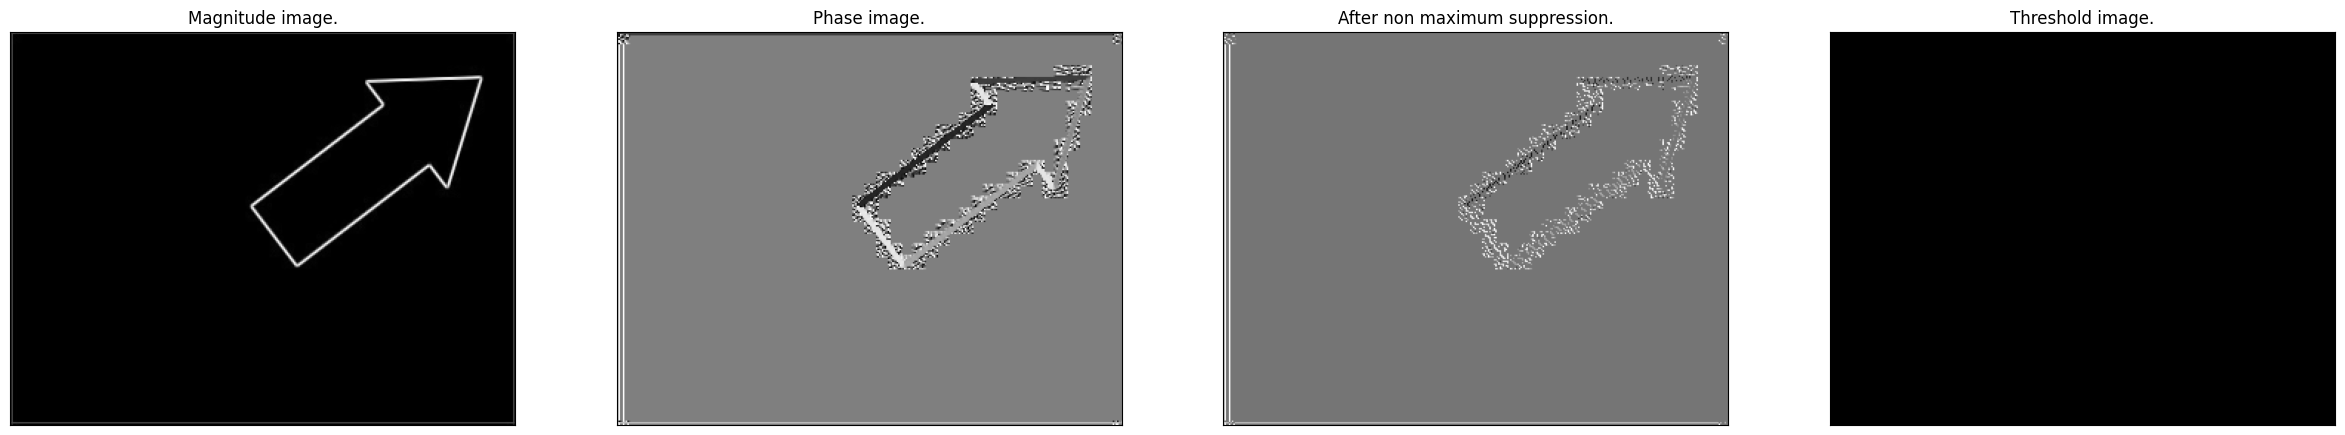

In [56]:
import cv2
import numpy as np
import matplotlib.pyplot as plt 

Im = cv2.imread("images/arrow_2.jpg", cv2.IMREAD_GRAYSCALE)

t_low = 100
t_high = 250
I_edges = my_cannyAlgorithm(Im, t_low, t_high)


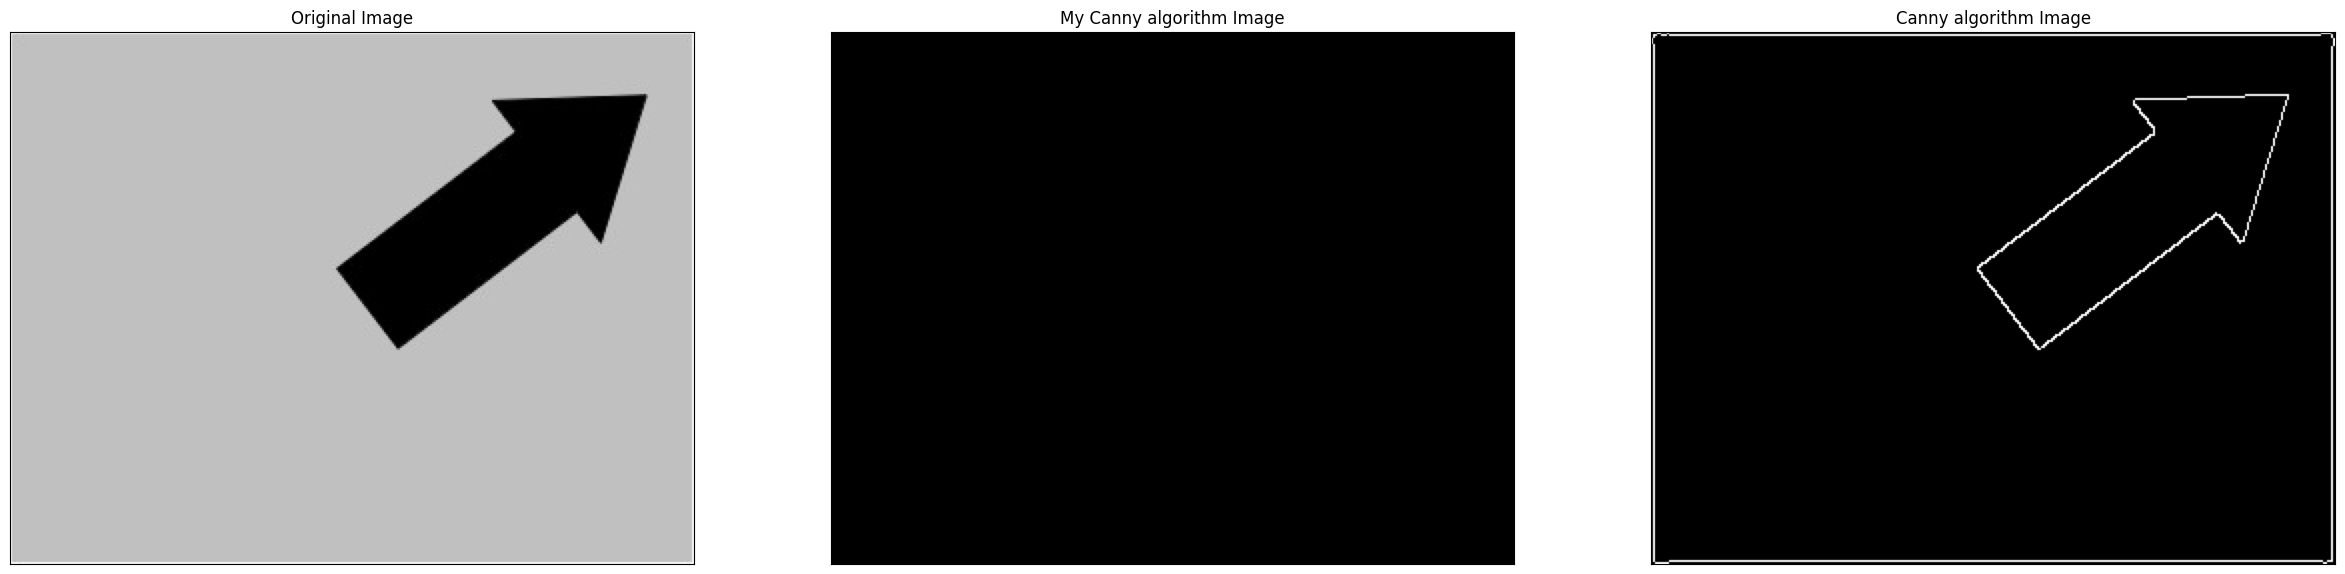

In [36]:
# LOCKED cell: useful to check and visualize the results.

plt.figure(figsize=(30,30))
plt.subplot(131), plt.imshow(Im, cmap='gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(I_edges, cmap='gray')
plt.title('My Canny algorithm Image'), plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(cv2.Canny(Im,t_low, t_high, L2gradient=False), cmap='gray')
plt.title('Canny algorithm Image'), plt.xticks([]), plt.yticks([])
plt.show()

# Problem 2

One of the most popular approaches to feature detection is the **Harris corner detector**, after a work of Chris Harris and Mike Stephens from 1988.

**a)** Use the function in opencv `cv2.cornerHarris(...)` ([Documentation](https://docs.opencv.org/master/dd/d1a/group__imgproc__feature.html#gac1fc3598018010880e370e2f709b4345)) with `blockSize=3, ksize=3, k=0.04` with the **./images/chessboard.png** image to detect the corners (you can find the image on CANVAS).

**b)** Plot the image with the detected corners found.

**Hint**: Use the function `cv2.drawMarker(...)` ([Documentation](https://docs.opencv.org/4.5.3/d6/d6e/group__imgproc__draw.html#ga644c4a170d4799a56b29f864ce984b7e)) to show the corners in the image.

**c)** Detect the corners using the images **./images/arrow_1.jpg**, **./images/arrow_2.jpg** and **./images/arrow_3.jpg**; describe and compare the results in the three images.

**d)** What happen if you change (increase/decrease) the `k` constant for the "corner points"? 


In [125]:
def detect_and_draw_corners(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    harris = cv2.cornerHarris(gray, 2, 3, 0.08)
    
    # Find corner positions
    threshold = 0.01 * harris.max()
    corner_image = np.zeros_like(image)
    corner_image[harris > threshold] = 255
    
    coords = np.column_stack(np.where(harris > threshold))
    
    # Create an image copy for drawing markers
    image_with_markers = image.copy()
    
    # Draw markers at the corner coordinates with a blue color
    for coord in coords:
        cv2.drawMarker(image_with_markers, tuple(coord), (255, 0, 0), markerType=cv2.MARKER_CROSS, markerSize=80, thickness=5)
    
    return image_with_markers

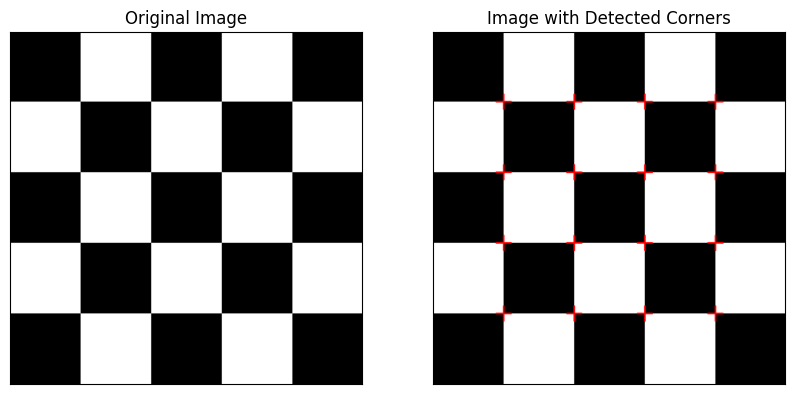

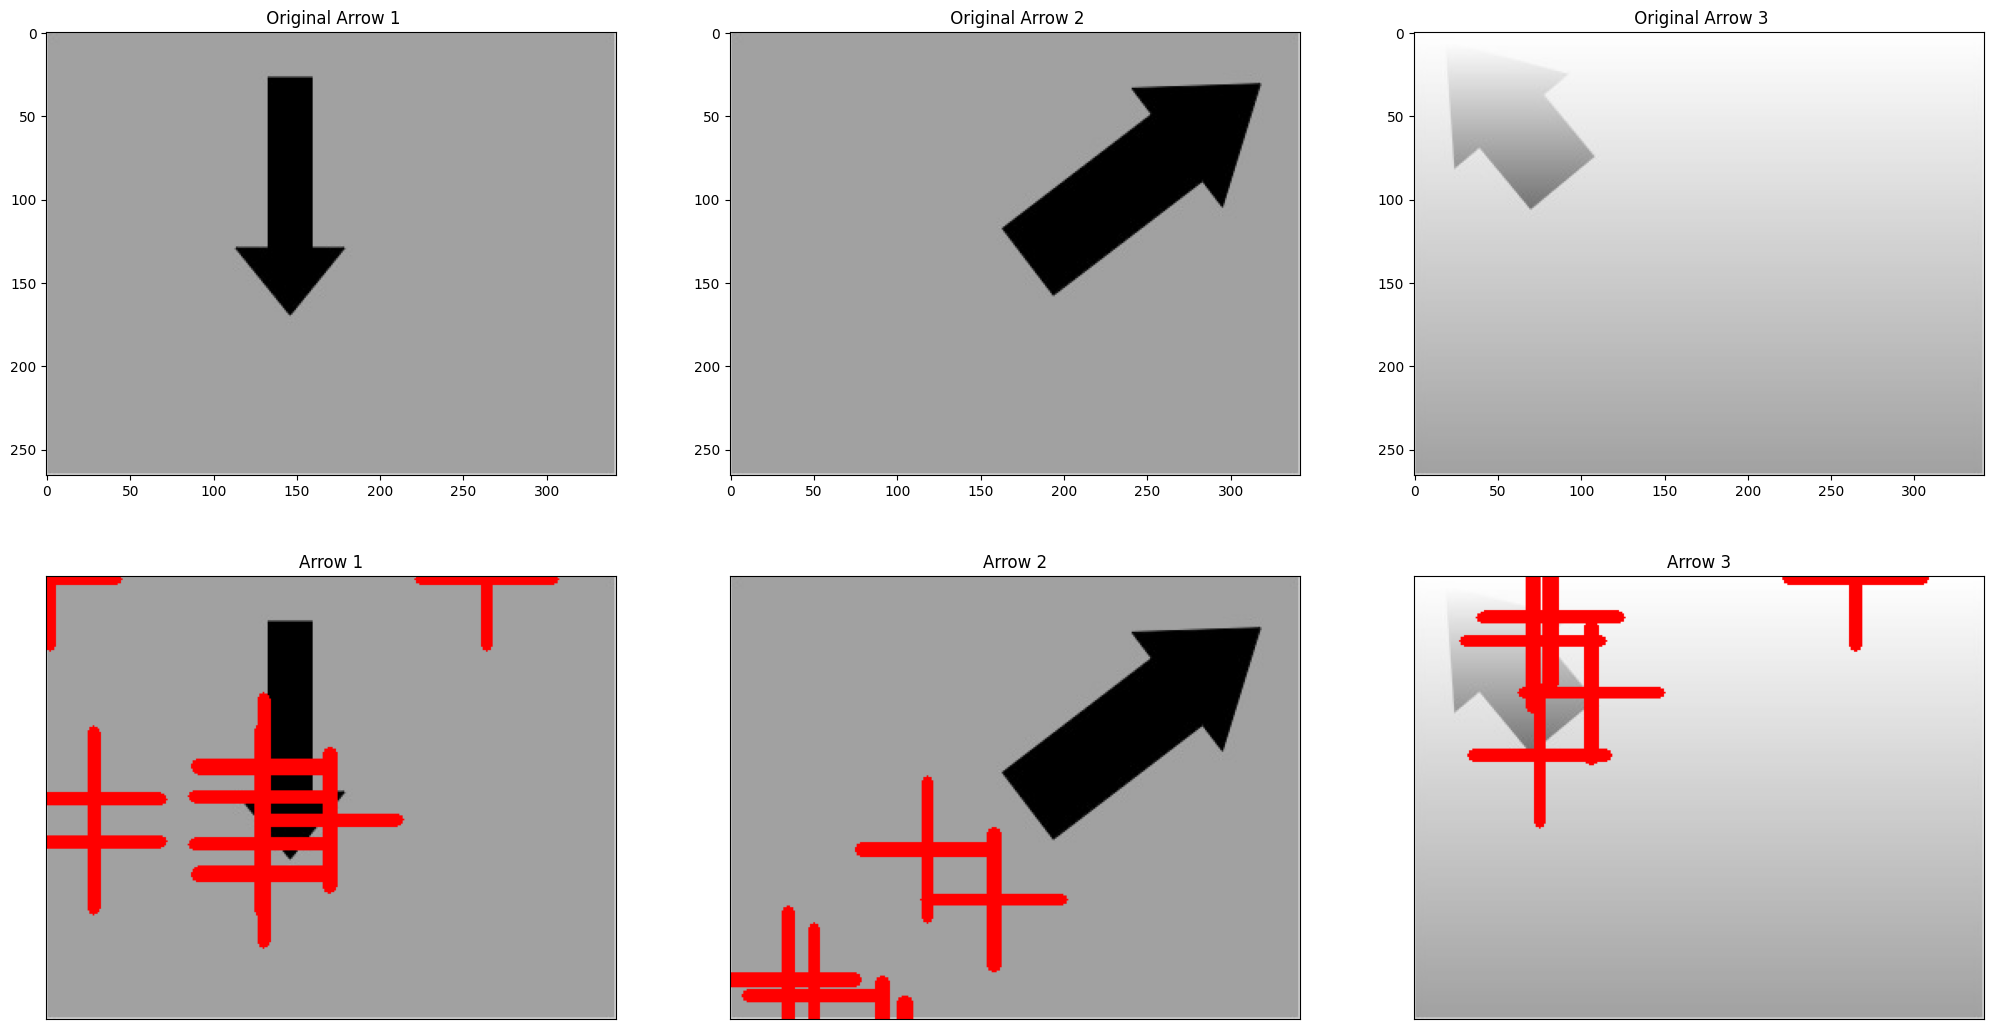

In [126]:
image = cv2.imread("images/chessboard.png")

image_with_markers = detect_and_draw_corners(image)

# Display the images
plt.figure(figsize=(10, 10))
plt.subplot(121), plt.imshow(image, cmap='gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(image_with_markers)
plt.title('Image with Detected Corners'), plt.xticks([]), plt.yticks([])
plt.show()

# Load the additional images
arrow_images = [
    cv2.imread("./images/arrow_1.jpg"),
    cv2.imread("./images/arrow_2.jpg"),
    cv2.imread("./images/arrow_3.jpg")
]

# Process and display the corner detection results for each arrow image
plt.figure(figsize=(25, 20))
for i, arrow_image in enumerate(arrow_images):
    result_image = detect_and_draw_corners(arrow_image)
    plt.subplot(3, 3, i + 1)
    plt.imshow(arrow_image)
    plt.title(f' Original Arrow {i+1}')
    plt.subplot(3, 3, i + 4)
    plt.imshow(result_image)
    plt.title(f'Arrow {i+1}')
    plt.xticks([]), plt.yticks([])

plt.show()



# Problem 3 

**a)** What is the SIFT approach? Describe the steps involved.

**b)** Why this approach is more popular than the Harris detector?

**c)** Explain the difference between a feature detector and a feature descriptor.

a) The SIFT (Scale-Invariant Feature Transform) Approach:

SIFT is a feature-based object recognition method used in computer vision and image processing. It is designed to identify and describe local features in images, which are distinctive and invariant to changes in scale, rotation, and illumination. The SIFT approach involves several key steps:

Scale-space Extrema Detection:

In this step, the image is progressively smoothed with Gaussian filters at different scales. This creates an image pyramid with varying levels of blur.
At each scale level, the algorithm looks for local extrema (maxima or minima) in the difference of Gaussian (DoG) images. These extrema represent potential key points.
Keypoint Localization:

For each candidate keypoint, SIFT performs precise localization by fitting a 3D quadratic function to the nearby DoG values. This localization process helps to refine the keypoint's position and scale.
Orientation Assignment:

SIFT assigns an orientation to each keypoint based on local image gradients. This allows SIFT descriptors to be rotation-invariant.
Descriptor Extraction:

A descriptor is computed for each keypoint. This descriptor is based on the gradient information in a local region around the keypoint. It encodes information about the keypoint's appearance and its surroundings.
Keypoint Matching:

To match keypoints between images, SIFT uses a distance metric (e.g., Euclidean distance) to compare the descriptors of keypoints in different images. Keypoints with the most similar descriptors are considered matches.
b) Popularity of SIFT vs. Harris Detector:

SIFT is more popular than the Harris corner detector for several reasons:

Invariance: SIFT features are designed to be invariant to scale, rotation, and minor changes in illumination. This makes them highly reliable in a wide range of situations, whereas the Harris corner detector is less invariant.
Distinctiveness: SIFT descriptors provide rich and distinctive information about keypoints, making them well-suited for accurate matching between images.
Robustness: SIFT can handle variations in viewpoint, lighting, and occlusion, which are common challenges in object recognition.
High Accuracy: SIFT is known for its accuracy in matching and locating features, making it a popular choice in tasks like image stitching, object recognition, and augmented reality.
Open Source: The SIFT algorithm was patented, but after the patent expired, open-source implementations became widely available, further boosting its popularity.
c) Difference between Feature Detector and Feature Descriptor:

Feature Detector: A feature detector is responsible for finding distinctive points or regions in an image. These points are often called keypoints. Feature detectors locate positions in an image that are unique or salient, making them suitable for matching and recognition tasks. For example, the Harris corner detector and the SIFT approach are feature detectors.

Feature Descriptor: A feature descriptor, on the other hand, provides a quantitative representation of the local image content around a detected keypoint. It encodes information about the intensity and gradient of pixels in the vicinity of the keypoint. Feature descriptors are used to create a compact and distinctive representation of the region around a keypoint, which can be used for matching and recognition. SIFT descriptors are a prominent example of feature descriptors. They are based on histograms of gradient orientations, providing a rich and distinctive description of the local image structure. Feature descriptors make it possible to compare and match keypoints between images.


### Delivery (dead line) on CANVAS: 13.10.2023 at 23:59


## Contact
### Course teacher
Professor Kjersti Engan, room E-431,
E-mail: kjersti.engan@uis.no

### Teaching assistant
Saul Fuster Navarro, room E-401
E-mail: saul.fusternavarro@uis.no


Jorge Garcia Torres Fernandez, room E-401
E-mail: jorge.garcia-torres@uis.no


## References

[1] S. Birchfeld, Image Processing and Analysis. Cengage Learning, 2016.

[2] I. Austvoll, "Machine/robot vision part I," University of Stavanger, 2018. Compendium, CANVAS.